In [41]:
import numpy as np
from tqdm import tqdm
import torch
import pickle as pkl
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:6') if use_cuda else torch.device('cpu')
if torch.cuda.is_available() == True:
    torch.cuda.set_device(6)
    
import seaborn as sns

In [42]:


class DynamicLearner(nn.Module):
    def __init__(self,channel=3,hidden_dim=8):
        super(DynamicLearner, self).__init__()
        '要走两个dynamic,因为涉及到转置操作再走非线性'
        hidden_dim = hidden_dim
#         channel = channel
        self.dynamic_learner1 = nn.Sequential(
            nn.Conv1d(1, channel, 3, padding=1, padding_mode='circular'),
            nn.ReLU(),
        )
        self.dynamic_learner2 = nn.Sequential(
            nn.Linear(channel,2),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.dynamic_learner1(x.unsqueeze(1))
        x = torch.transpose(x,2,1)
        x = self.dynamic_learner2(x)
        x = F.softmax(x,dim=2)
        return x

# 粗粒化过程
class RenormNet(nn.Module):
    def __init__(self,node_size,group_size):
        super(RenormNet, self).__init__()
        channel=3
        hidden_dim = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(1, channel, group_size, stride=group_size),
            nn.LeakyReLU()
        )
        self.network1 = nn.Sequential(
            nn.Linear(channel,2),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, channel, group_size,stride=group_size),
            nn.LeakyReLU()
        )
        self.network2 = nn.Sequential(
            nn.Linear(channel,2),
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        return x#encoder,macro_pred,decoder
    
    def Encoder(self,x):
        encoder = self.encoder(x.unsqueeze(1))#.squeeze(0)
        encoder = encoder.permute(0,2,3,1)#torch.transpose(torch.transpose(encoder,0,1),1,2)
        encoder = self.network1(encoder)#.squeeze(2)
        encoder = F.softmax(encoder,dim=-1)
        return encoder
    
    def Decoder(self,x):
        x = self.decoder(x.unsqueeze(1))#.squeeze(0)
        x = x.permute(0,2,3,1)#torch.transpose(torch.transpose(x,0,1),1,2)
        x = self.network2(x)
        decoder = F.softmax(x,dim=-1)
        return decoder
        
    

In [43]:

N2_self_rules = [3,252,192,63,51,136,238,204,85,170,240,15,60,195]
# N2_self_rules = [90,102,150,153,165]
rules = [38,45,54,62,82,84,86]
rules.extend(N2_self_rules)

NEAR_0 = 1e-10

In [44]:
'load data...'
rule=102
print('rule:',rule)
if rule in N2_self_rules:
    print('self_similar')

with open(f'../../../data/CA/CA_data_{rule}.pkl','rb') as f:
    data = pkl.load(f)['histories']

group_size=3
np.random.seed(2)
random_index = np.random.randint(0,99)
print(random_index)
data = torch.tensor(data[random_index,:,:],dtype=torch.float) #random choice a sample
print(data.shape)

rule: 102
40
torch.Size([180, 120])


In [45]:
data.shape

torch.Size([180, 120])

In [46]:
dynamic = torch.load(f'./models/{rule}_dynamic.pth',map_location=torch.device('cpu'))
dynamic

DynamicLearner(
  (dynamic_learner1): Sequential(
    (0): Conv1d(1, 5, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    (1): ReLU()
  )
  (dynamic_learner2): Sequential(
    (0): Linear(in_features=5, out_features=2, bias=True)
    (1): ReLU()
  )
)

In [47]:
model = torch.load(f'./models/new_{rule}_model_group_size={group_size}.pth',map_location=torch.device('cpu'))
# model = torch.load(f'../models/CA/{rule}_model_group_size={group_size}.pth',map_location=torch.device('cpu'))

dynamic = model['dynamic']
renorm = model['renorm']

In [48]:
def set_plot_basicinf(ylabel,xlabel,fontsize=14):
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.xlabel(xlabel,fontsize=fontsize)

In [49]:
colors = sns.color_palette('GnBu_r',10)
colors

[(0.03137254901960784, 0.36416762783544787, 0.6275586312956556),
 (0.09219530949634756, 0.47040369088811995, 0.7057900807381776),
 (0.19123414071510958, 0.5742099192618224, 0.7586620530565167),
 (0.29457900807381776, 0.6893656286043829, 0.8206689734717416),
 (0.4186851211072664, 0.7646289888504422, 0.7898500576701268),
 (0.5460207612456748, 0.8240522875816993, 0.7474048442906575),
 (0.6704498269896194, 0.8711880046136101, 0.7149711649365629),
 (0.7767474048442907, 0.9125259515570934, 0.7622145328719724),
 (0.8436755094194541, 0.939038831218762, 0.8205920799692425),
 (0.9035447904652056, 0.9627681660899654, 0.881753171856978)]

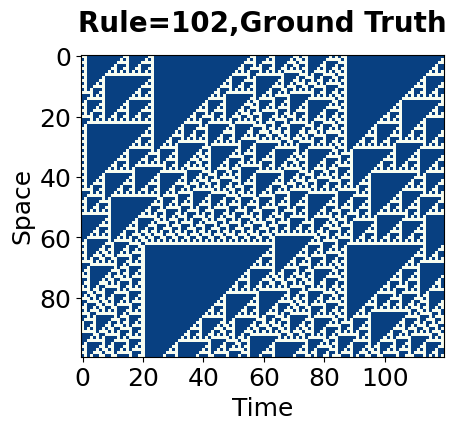

torch.Size([180, 120])


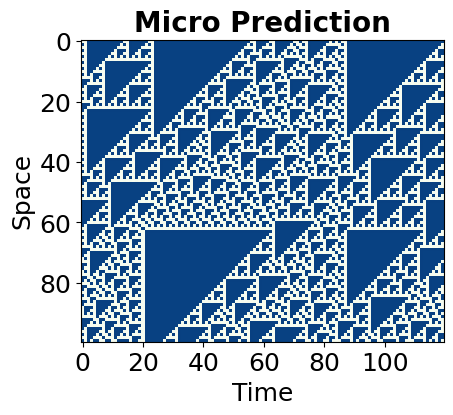

tensor(0.0013, grad_fn=<MseLossBackward0>)

In [50]:
'single step micro prediction'
fontsize = 20
plt.figure(dpi=100)
plt.imshow(data[1:,:][:100],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title(f'Rule={rule},Ground Truth',x=0.5,y=1.05,fontsize=fontsize,fontweight='bold')
plt.show()
plt.figure(dpi=100)
t,s = data.shape
pred = dynamic(data)[:,:,1]
print(pred.shape)
plt.imshow(pred[:-1,:][:100].detach(),cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title('Micro Prediction',fontsize=fontsize,fontweight='bold')
plt.show()

MSE = nn.MSELoss()
# print(test_data_x.shape,pred.shape)
MSE(data[1:,:], pred[:-1,:])

(512, 3, 3)


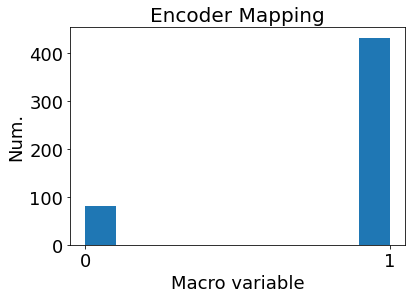

In [30]:
'encoder rules'
x = np.array([list(map(int, format(i, '09b'))) for i in range(2**9)]).reshape(-1,3,3)
print(x.shape)
x = torch.tensor(x,dtype=torch.float)
y = renorm.Encoder(x).max(3)[1]
plt.hist(y.reshape(-1))
set_plot_basicinf('Num.','Macro variable',fontsize-2)
plt.title('Encoder Mapping',fontsize=fontsize)
plt.xticks([0,1])
plt.show()

torch.Size([60, 40])
torch.Size([60, 40, 2])
renorm + dynamic torch.Size([60, 40])


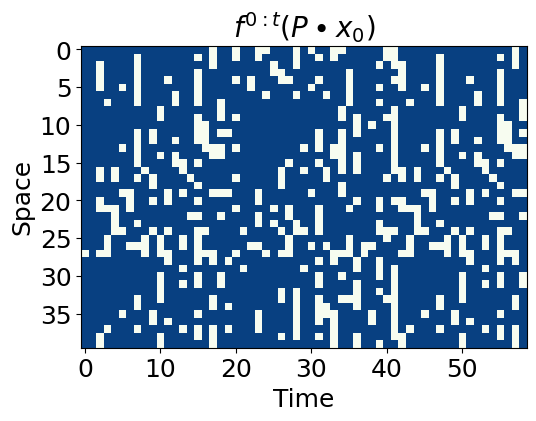

torch.Size([60, 40, 2])
dynamic +renorm torch.Size([60, 40, 2])


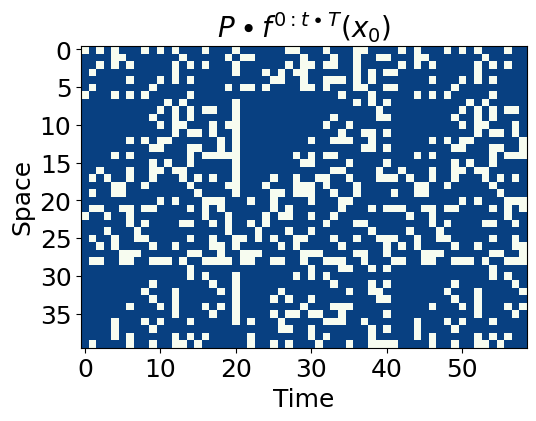

In [51]:
'muti-step coarse-graining'
fontsize = 20
plt.figure(dpi=100)
t,s = data.shape

# plt.figure(dpi=100)
encoder1 = renorm.Encoder(data.unsqueeze(0))[0,:,:,1]
print(encoder1.shape)

macro_pred = dynamic(encoder1)
print(macro_pred.shape)
plt.imshow(macro_pred.detach().max(2)[1][:-1].T,cmap='GnBu_r')
print('renorm + dynamic',encoder1.shape)
set_plot_basicinf('Space','Time',fontsize-2)
plt.title(r'$f^{0:t}(P \bullet x_0)$',fontsize=fontsize,fontweight='bold')
plt.show()

plt.figure(dpi=100)
encoder2 = renorm.Encoder(data.unsqueeze(0))[0,:,:,:]
print(encoder2.shape)
print('dynamic +renorm',encoder2.shape)
# plt.imshow(encoder2.detach().max(2)[1].T,cmap='GnBu_r')
plt.imshow(encoder2.detach().min(2)[1][1:].T,cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
plt.title(r'$P \bullet f^{0:t \bullet T}(x_0)$',fontsize=fontsize,fontweight='bold')
plt.show()

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.]]) torch.Size([1, 1, 40])
renorm + dynamic torch.Size([1, 1, 40, 2])


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


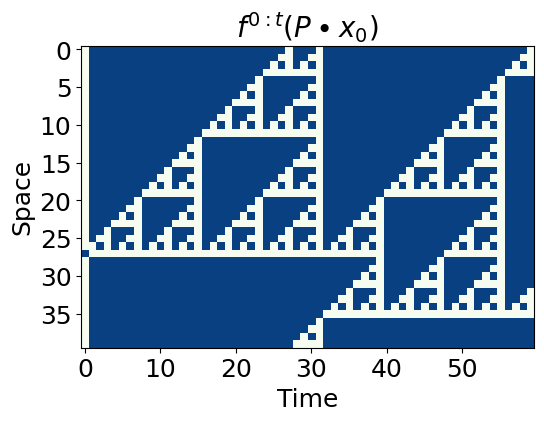

dynamic +renorm torch.Size([1, 59, 40, 2])


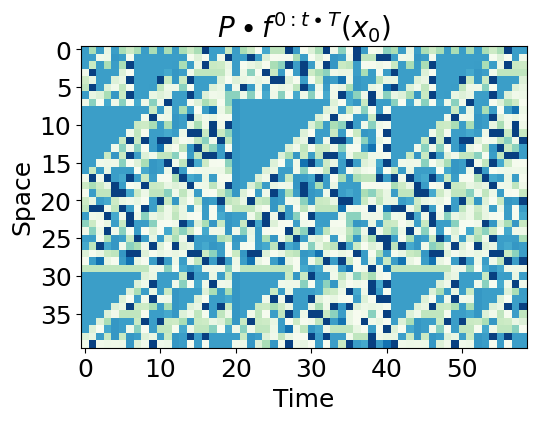

In [52]:
'muti-step coarse-graining, each macro state should be sampled as binary value before input'
fontsize = 20
plt.figure(dpi=100)
data_test = data.unsqueeze(0)
b,t,s = data_test.shape
preds = torch.zeros(b,t//group_size, s//group_size)
preds.shape
# plt.figure(dpi=100)
encoder1 = renorm.Encoder(data_test[:,0:group_size,:])
preds[:,0:1,:] = torch.tensor(encoder1.max(3)[1],dtype=torch.float)
print(preds[0,0:1,:],preds[:,0:1,:].shape)
for i in range(t//group_size):
    macro_pred = dynamic(preds[:,i:i+1,:].reshape(-1,s//group_size)).reshape(b,1,s//group_size,2)
    preds[:,i+1:i+2,:] = macro_pred.max(3)[1]
index=0
plt.imshow(preds[index,:,:].T,cmap='GnBu_r')

print('renorm + dynamic',encoder1.shape)
set_plot_basicinf('Space','Time',fontsize-2)
plt.title(r'$f^{0:t}(P \bullet x_0)$',fontsize=fontsize,fontweight='bold')
plt.show()

plt.figure(dpi=100)
encoder2 = renorm.Encoder(data_test[:,group_size:,:])
print('dynamic +renorm',encoder2.shape)
plt.imshow(encoder2[index,:,:,1].detach().T,cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
plt.title(r'$P \bullet f^{0:t \bullet T}(x_0)$',fontsize=fontsize,fontweight='bold')
plt.show()

In [53]:
MSE(preds[:,1:,:].reshape(-1), encoder2[:,:,:,1].reshape(-1))

tensor(0.4440, grad_fn=<MseLossBackward0>)

torch.Size([1, 59, 40])
torch.Size([1, 59, 40])


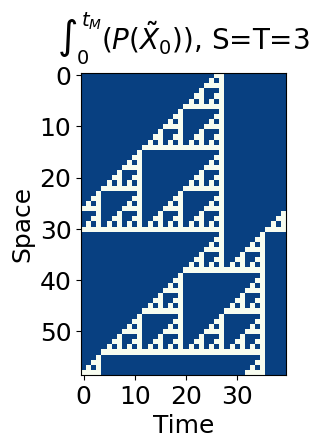

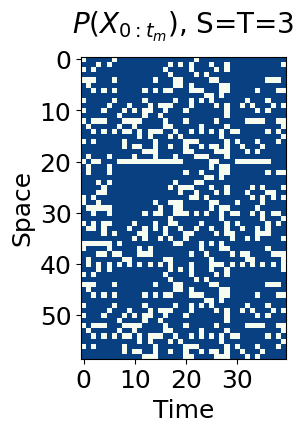

tensor(0.3263)

In [56]:
'sample from macro-state'
preds1 = preds[:,1:,:]
encoder2 = renorm.Encoder(data_test[:,group_size:,:])
# preds2 = encoder2.max(3)[1]
preds2 = encoder2.min(3)[1]
print(preds1.shape)
print(preds2.shape)
fontsize = 20
plt.figure(dpi=100)
plt.imshow(preds1[index,:,:].detach(),cmap='GnBu_r')

set_plot_basicinf('Space','Time',fontsize-2)
plt.title(r'$\int_0^{t_M}(P (\tilde{X}_0))$'+f', S=T={group_size}',x=0.5,y=1.05,fontsize=fontsize)
plt.show()

fontsize = 20
plt.figure(dpi=100)

plt.imshow(preds2[index,:,:].detach(),cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
plt.title(r"$P ({X}_{0:t_m})$"+f', S=T={group_size}',x=0.5,y=1.05,fontsize=fontsize)
plt.show()
MAE = nn.NLLLoss()
MSE = nn.MSELoss()
MSE(preds1.reshape(-1), preds2.reshape(-1))

## reconstruction error

In [122]:
'load data...'
rule=85
print('rule:',rule)
if rule in N2_self_rules:
    print('self_similar')

with open(f'../../../data/CA/CA_data_{rule}.pkl','rb') as f:
    data = pkl.load(f)['histories']

group_size=3
data = torch.tensor(data[-10,:120,:],dtype=torch.float) #random choice a sample
print(data.shape)


dynamic = torch.load(f'./models/{rule}_dynamic.pth',map_location=torch.device('cpu'))
seed = 2050
'self'
models = torch.load(f'./models/new_{rule}_model_group_size={group_size}.pth',map_location=torch.device('cpu'))
dynamic = models['dynamic']
renorm = models['renorm']


rule: 85
self_similar
torch.Size([120, 120])


torch.Size([120, 120])
torch.Size([1, 40, 40, 2])
torch.Size([40, 40, 2])
torch.Size([120, 120, 2])


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


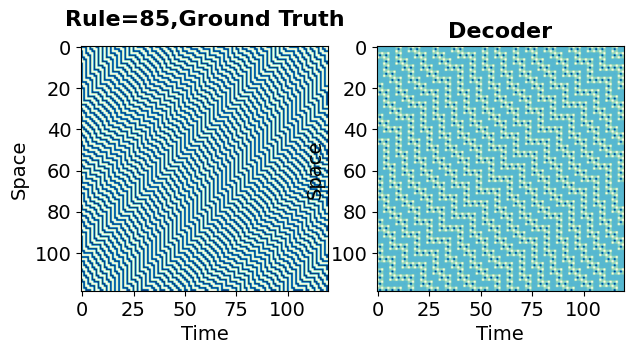

group size=3,MSE=0.4185


In [123]:
# group_size=3
data = torch.tensor(data[:120,:],dtype=torch.float) #random choice a sample
print(data.shape)

encoder = renorm.Encoder(data.unsqueeze(0))
print(encoder.shape)
encoder = torch.tensor(encoder.max(3)[1],dtype=torch.float)
macro_pred = dynamic(encoder[0,:,:])
print(macro_pred.shape)
decoder = renorm.Decoder(macro_pred[:,:,1].unsqueeze(0))[0,:,:]
print(decoder.shape)

fontsize = 16
plt.figure(dpi=100,figsize=(7,4))
plt.subplot(121)
plt.imshow(data[1:,],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title(f'Rule={rule},Ground Truth',x=0.5,y=1.05,fontsize=fontsize,fontweight='bold')


plt.subplot(122)
plt.imshow(decoder.detach()[:-1,:,1],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120])
plt.title('Decoder',fontsize=fontsize,fontweight='bold')
plt.show()

# MSE = nn.MSELoss()
# MSE = nn.NLLLoss()
def MSE(data,pred):
    return torch.mean(abs(data-pred))
# MSE = nn.KLDivLoss()
near_zero =1e-10
loss = MSE(data[group_size:,:].reshape(-1), decoder[:-group_size,:,1].reshape(-1))
# loss = MSE(torch.log(data[group_size:,:].reshape(-1)+near_zero), decoder[:-group_size,:,1].reshape(-1)+near_zero)
print(f'group size={group_size},MSE={loss:.4f}')


## self-similar vs unself-similar framework

In [57]:
'load data...'
rule=85
print('rule:',rule)
if rule in N2_self_rules:
    print('self_similar')

with open(f'../../../data/CA/CA_data_{rule}.pkl','rb') as f:
    data = pkl.load(f)['histories']



rule: 85
self_similar
torch.Size([120, 120])


In [58]:
def set_plot_basicinf(ylabel,xlabel,fontsize=14):
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.xlabel(xlabel,fontsize=fontsize)

In [59]:

dynamic = torch.load(f'./models/{rule}_dynamic.pth',map_location=torch.device('cpu'))
seed = 2050
'self'
models = torch.load(f'./models/new_{rule}_model_group_size={group_size}_{seed}.pth',map_location=torch.device('cpu'))
dynamic = models['dynamic']
renorm = models['renorm']

'unself'
models = torch.load(f'./models/unself_{rule}_model_group_size={group_size}_{seed}.pth')
macro_dynamic = models['dynamic']
unself_renorm = models['renorm']

torch.Size([1, 40, 40, 2])
torch.Size([40, 40, 2])
torch.Size([120, 120, 2])


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


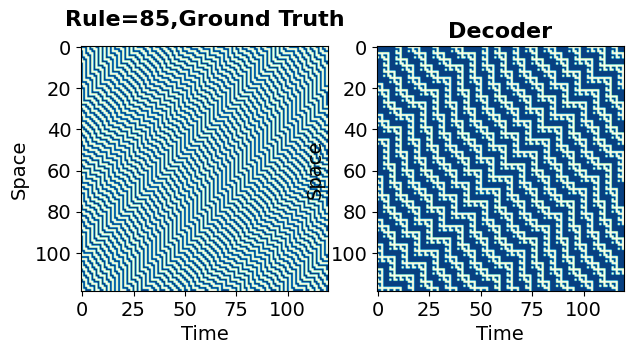

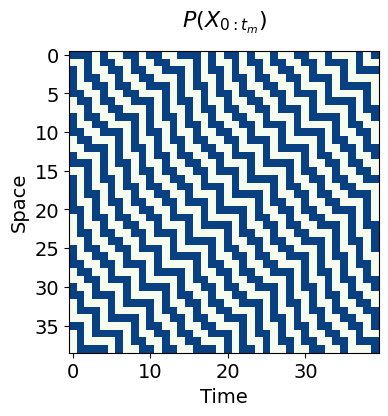

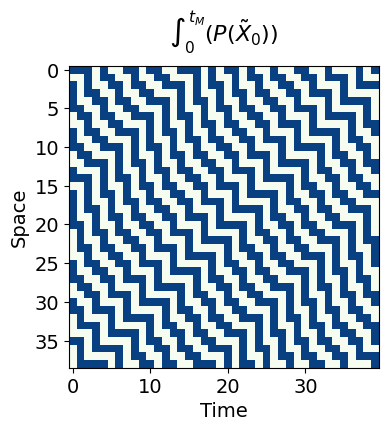

tensor(9.5328e-05, grad_fn=<MseLossBackward0>)

In [60]:
'self'
encoder = renorm.Encoder(data.unsqueeze(0))
print(encoder.shape)
encoder = torch.tensor(encoder.max(3)[1],dtype=torch.float)
macro_pred = dynamic(encoder[0,:,:])
print(macro_pred.shape)
decoder = renorm.Decoder(macro_pred[:,:,1].unsqueeze(0))[0,:,:]
print(decoder.shape)

fontsize = 16
plt.figure(dpi=100,figsize=(7,4))
plt.subplot(121)
plt.imshow(data[1:,],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title(f'Rule={rule},Ground Truth',x=0.5,y=1.05,fontsize=fontsize,fontweight='bold')


plt.subplot(122)
plt.imshow(decoder.detach()[:-1,:].max(2)[1],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120])
plt.title('Decoder',fontsize=fontsize,fontweight='bold')
plt.show()

MSE = nn.MSELoss()
MSE(data[group_size:,:].reshape(-1), decoder[:-group_size,:].max(2)[1].reshape(-1))
plt.figure(dpi=100)
plt.imshow(encoder.detach()[0,1:,:],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title(r"$P ({X}_{0:t_m})$",x=0.5,y=1.05,fontsize=fontsize)
plt.show()

plt.figure(dpi=100)
plt.imshow(macro_pred[:-1,:,:].detach().max(2)[1],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title(r'$\int_0^{t_M}(P (\tilde{X}_0))$',x=0.5,y=1.05,fontsize=fontsize)
plt.show()




MSE(encoder[0,1:,:].reshape(-1), macro_pred[:-1,:,1].reshape(-1))

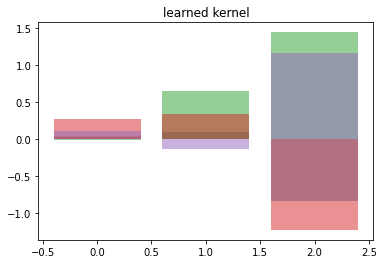

--


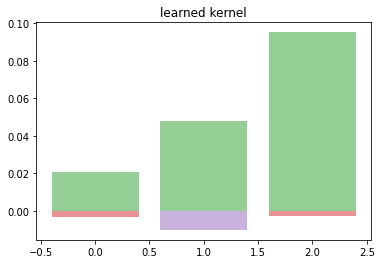

In [14]:
'visualiza the learned kernel'
for idx,param in enumerate(dynamic.parameters()):
    if idx == 0:
        for i in range(param.shape[0]):
            plt.bar(range(3),param[i,0,:].detach(),label='self',alpha=0.5)
            plt.title(f'learned kernel')
        plt.show()
print('--')
for idx,param in enumerate(macro_dynamic.parameters()):
    if idx == 0:
        for i in range(param.shape[0]):
            plt.bar(range(3),param[i,0,:].detach(),label='unself',alpha=0.5)
            plt.title(f'learned kernel')
        plt.show()
    

torch.Size([1, 40, 40, 2])
torch.Size([40, 40, 2])
torch.Size([120, 120, 2])


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


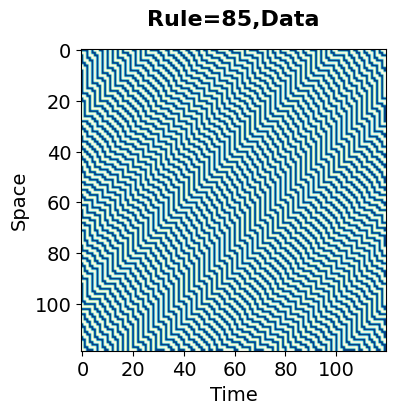

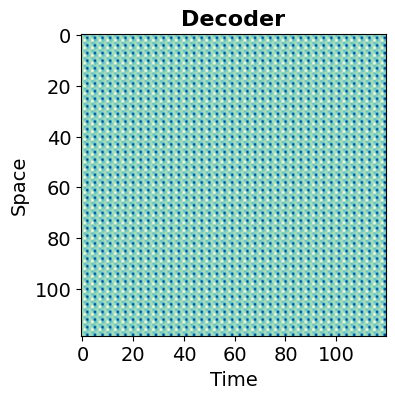

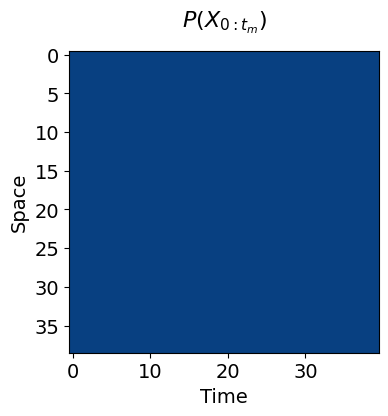

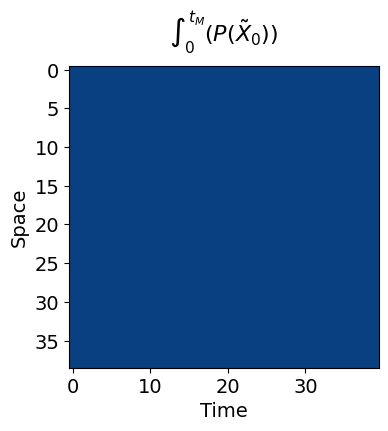

tensor(0.2500, grad_fn=<MseLossBackward0>)

In [15]:
'unself'
encoder = unself_renorm.Encoder(data.unsqueeze(0))
print(encoder.shape)
encoder = torch.tensor(encoder.max(3)[1],dtype=torch.float)
macro_pred = macro_dynamic(encoder[0,:,:])
print(macro_pred.shape)
decoder = unself_renorm.Decoder(macro_pred[:,:,1].unsqueeze(0))[0,:,:]
print(decoder.shape)

fontsize = 16
plt.figure(dpi=100)
plt.imshow(data[1:,],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title(f'Rule={rule},Data',x=0.5,y=1.05,fontsize=fontsize,fontweight='bold')
plt.show()

plt.figure(dpi=100)
plt.imshow(decoder.detach()[:-1,:,1],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title('Decoder',fontsize=fontsize,fontweight='bold')
plt.show()

MSE = nn.MSELoss()
MSE(data[group_size:,:].reshape(-1), decoder[:-group_size,:].max(2)[1].reshape(-1))


plt.figure(dpi=100)
plt.imshow(encoder.detach()[0,1:,:],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title(r"$P ({X}_{0:t_m})$",x=0.5,y=1.05,fontsize=fontsize)
plt.show()

plt.figure(dpi=100)
plt.imshow(macro_pred[:-1,:,:].detach().max(2)[1],cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize-2)
# plt.yticks([0,40,80,120,160])
plt.title(r'$\int_0^{t_M}(P (\tilde{X}_0))$',x=0.5,y=1.05,fontsize=fontsize)
plt.show()


MSE(encoder[0,1:,:].reshape(-1), macro_pred[:-1,:,1].reshape(-1))

In [112]:
'3  times experiments'
unself_losses = {}
self_losses = {}
rule=85
for seed in [2050,2052,2053]:
    with open(f'./data/loss_unself_{rule}_{seed}.pkl','rb') as f:
        unself_losses[seed] = pkl.load(f)
        print(len(unself_losses[seed]['valid'])-31)
    with open(f'./data/loss_self_{rule}_{seed}.pkl','rb') as f:
        self_losses[seed] = pkl.load(f)
        print(len(self_losses[seed]['valid'])-31)
        print()

61
107

86
128

44
128



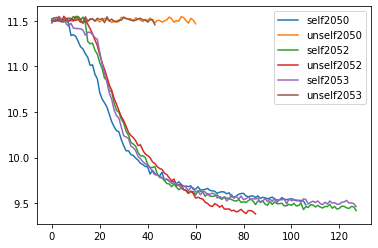

In [113]:
for seed in [2050,2052,2053]:
    plt.plot(self_losses[seed]['valid'][:-31],label=f'self{seed}')
    plt.plot(unself_losses[seed]['valid'][:-31],label=f'unself{seed}')
plt.legend()




In [115]:
colors = sns.color_palette('RdYlGn_r',6)
colors

[(0.2246828143021916, 0.6558246828143023, 0.34440599769319497),
 (0.6165321030372936, 0.8359092656670511, 0.41191849288735105),
 (0.8918877354863515, 0.954479046520569, 0.6010765090349867),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9873125720876587, 0.647366397539408, 0.36424452133794694),
 (0.8899653979238754, 0.28673587081891583, 0.19815455594002307)]

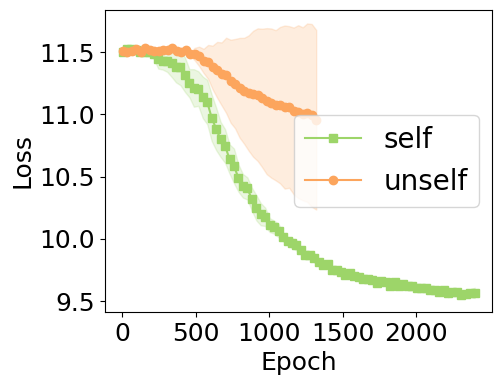

In [117]:
plt.figure(dpi=100,figsize=(5,4))
fontsize=20
cut_time = 80
xx = np.linspace(1,cut_time*30,cut_time)

yy = np.array([i['valid'][:cut_time] for i in self_losses.values()])
plt.plot(xx,np.mean(yy,axis=0),label='self',marker='s',color=colors[1])
plt.fill_between(xx,np.mean(yy,axis=0)-np.std(yy,axis=0),np.mean(yy,axis=0)+np.std(yy,axis=0),
                 color=colors[1],alpha=0.2)

cut_time = 44
xx = np.linspace(1,cut_time*30,cut_time)
yy = np.array([i['valid'][:cut_time] for i in unself_losses.values()])
plt.plot(xx,np.mean(yy,axis=0),label='unself',marker='o',color=colors[4])
plt.fill_between(xx,np.mean(yy,axis=0)-np.std(yy,axis=0),np.mean(yy,axis=0)+np.std(yy,axis=0),
                 color=colors[4],alpha=0.2)
plt.legend(fontsize=fontsize)
plt.xticks([0,500,1000,1500,2000])
set_plot_basicinf('Loss','Epoch',fontsize-2)
plt.show()